## Q1

In [1]:
import numpy as np
from pymoo.problems.functional import FunctionalProblem
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch  # Hooke-Jeeves的對應方法
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.optimize import minimize

# 固定參數
a = 200   # 需求基值
b = 35    # 價格敏感度
v = 0.5   # 殘值
c = 1.0   # 成本
s = 1.0   # 缺貨成本
simulations = 5000  # 模擬次數

def calculate_profit(Q, p, epsilon_samples):
    profits = []
    for epsilon in epsilon_samples:
        demand = a - b * p + epsilon
        sales = min(Q, demand)
        surplus = max(Q - demand, 0)
        shortage = max(demand - Q, 0)

        profit = (p * sales) - (c * Q) + (v * surplus) - (s * shortage)
        profits.append(profit)
    return np.mean(profits)

def objective_function(x, epsilon_samples):
    # x=[Q, p]
    Q, p = x
    # 範圍限制
    if Q < 10 or Q > 200 or p < 1 or p > 5.5:
        return np.inf
    # 回傳負的利潤(目標為最小化此值,等效於最大化利潤)
    return -calculate_profit(Q, p, epsilon_samples)

def solve_problem(epsilon_samples, method="PatternSearch"):
    # 定義優化問題
    problem = FunctionalProblem(
        n_var=2,
        objs=lambda x: objective_function(x, epsilon_samples),
        xl=np.array([10, 1]),   # Q下界=10, p下界=1
        xu=np.array([200, 5.5]) # Q上界=200, p上界=5.5
    )

    # 選擇演算法 (Hooke-Jeeves 用 PatternSearch，或 NelderMead)
    if method == "PatternSearch":
        algorithm = PatternSearch()
    elif method == "Nelder-Mead":
        algorithm = NelderMead()

    # 最小化問題
    res = minimize(problem, algorithm)

    # 由於目標為負利潤，故最大利潤 = -res.F
    optimal_Q, optimal_p = res.X
    max_profit = -res.F[0]
    return optimal_Q, optimal_p, max_profit

if __name__ == "__main__":
    # (1) 常態分布 epsilon
    epsilon_samples_normal = np.random.normal(0, 20, simulations)
    Q_nm, p_nm, prof_nm = solve_problem(epsilon_samples_normal, method="Nelder-Mead")
    print(f"[常態分布 - Nelder-Mead] Q*: {Q_nm:.2f}, p*: {p_nm:.2f}, 最大期望利潤: {prof_nm:.2f}")

    Q_hj, p_hj, prof_hj = solve_problem(epsilon_samples_normal, method="PatternSearch")
    print(f"[常態分布 - Hooke-Jeeves] Q*: {Q_hj:.2f}, p*: {p_hj:.2f}, 最大期望利潤: {prof_hj:.2f}")

    # (2) 指數分布 epsilon
    epsilon_samples_exp = np.random.exponential(10, simulations)
    Q_nm_exp, p_nm_exp, prof_nm_exp = solve_problem(epsilon_samples_exp, method="Nelder-Mead")
    print(f"[指數分布 - Nelder-Mead] Q*: {Q_nm_exp:.2f}, p*: {p_nm_exp:.2f}, 最大期望利潤: {prof_nm_exp:.2f}")

    Q_hj_exp, p_hj_exp, prof_hj_exp = solve_problem(epsilon_samples_exp, method="PatternSearch")
    print(f"[指數分布 - Hooke-Jeeves] Q*: {Q_hj_exp:.2f}, p*: {p_hj_exp:.2f}, 最大期望利潤: {prof_hj_exp:.2f}")


[常態分布 - Nelder-Mead] Q*: 106.38, p*: 3.35, 最大期望利潤: 180.29
[常態分布 - Hooke-Jeeves] Q*: 106.37, p*: 3.35, 最大期望利潤: 180.29
[指數分布 - Nelder-Mead] Q*: 98.76, p*: 3.48, 最大期望利潤: 207.97
[指數分布 - Hooke-Jeeves] Q*: 98.75, p*: 3.48, 最大期望利潤: 207.97


## Q2

### Q2-1

Optimal production quantity: 12600 shirts
Maximum expected profit: $144015.02


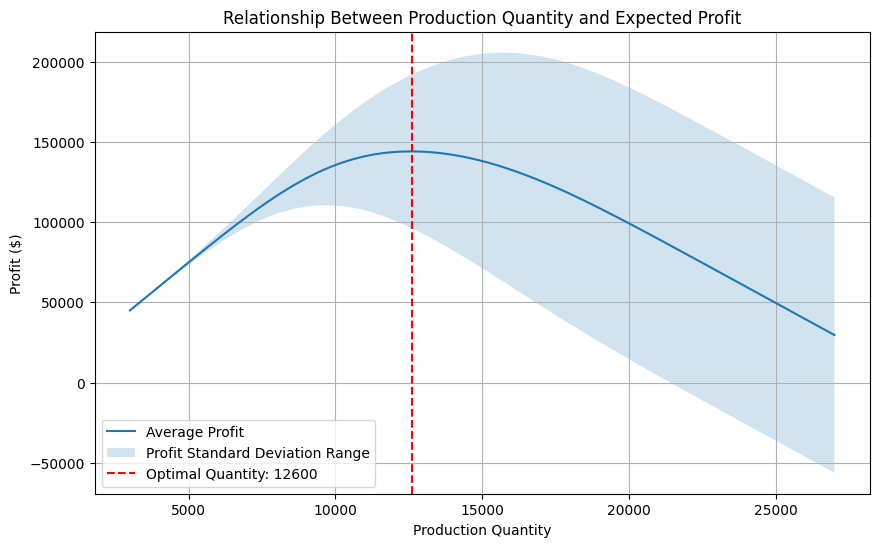

In [2]:
#2.1
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1234)

# 常數參數
CostPerShirt = 10  # 每件生產成本
PreGamePrice = 25  # 比賽前售價
PostGamePriceWin = 25  # 比賽後勝利售價
PostGamePriceLose = 12.5  # 比賽後落敗售價
ProbWin = 0.4  # 勝利機率

# 需求分布參數
PreGameMean, PreGameStd = 9000, 2000  # 比賽前需求分布
PostGameWinMean, PostGameWinStd = 6000, 2000  # 勝利後需求分布
PostGameLoseMean, PostGameLoseStd = 2000, 1000  # 落敗後需求分布
KLose = (PostGameLoseMean / PostGameLoseStd)**2
ThetaLose = PostGameLoseStd**2 / PostGameLoseMean

# 模擬參數
QRange = np.arange(3000, 27001, 100)  # 生產數量範圍
Simulations = 10000  # 模擬次數

# 儲存結果
SimProfit = np.zeros((Simulations, len(QRange)))

# 模擬需求和計算利潤
for s in range(Simulations):
    PreGameDemand = np.random.normal(PreGameMean, PreGameStd)  # 比賽前需求
    if np.random.random() < ProbWin:  # 勝利情況 np.random.random() 生成的是介於0~1
        PostGameDemand = np.random.normal(PostGameWinMean, PostGameWinStd)
        PostGamePrice = PostGamePriceWin
    else:  # 落敗情況
        PostGameDemand = np.random.gamma(KLose, ThetaLose)
        PostGamePrice = PostGamePriceLose

    for i, Q in enumerate(QRange):
        # i 是迴圈的索引，表示目前迴圈運行的次數（第幾次迴圈）
        # Q 是對應於 QRange 中的某個生產數量（迴圈當前的生產數量值）

        # # 生產總成本
        TotalCost = Q * CostPerShirt

        # 比賽前銷售收入
        PreGameSales = min(Q, PreGameDemand) * PreGamePrice

        # 剩餘庫存
        RemainingStock = max(0, Q - PreGameDemand)

        # 比賽後銷售收入
        PostGameSales = min(RemainingStock, PostGameDemand) * PostGamePrice

        # 總利潤 = 總收入 - 生產成本

        # 陣列 SimProfit
        # SimProfit 是一個 2D 陣列，形狀為 (Simulations, len(QRange))。
        # 行數（Simulations）：代表模擬的次數。
        # 列數（len(QRange)）：代表每個生產數量Q的利潤。
        SimProfit[s, i] = PreGameSales + PostGameSales - TotalCost

# # 計算平均和標準差
# axis=0：沿著「行」的方向進行操作，由上到下
# axis=1：沿著「列」的方向進行操作，由左到右
# SimProfit =
# [[1500, 2000, 2500],  # 第一次模擬，不同生產數量的利潤
#  [1400, 2100, 2400],  # 第二次模擬，不同生產數量的利潤
#  [1600, 1900, 2600]]  # 第三次模擬，不同生產數量的利潤
# AvgProfit = [
    # mean([1500, 1400, 1600]),
    # mean([2000, 2100, 1900]),
    # mean([2500, 2400, 2600])
    #]
#      = [1500, 2000, 2500]
AvgProfit = SimProfit.mean(axis=0)
SdProfit = SimProfit.std(axis=0)
OptimalQ = QRange[np.argmax(AvgProfit)]
MaxProfit = AvgProfit.max()

# 結果輸出
print(f"Optimal production quantity: {OptimalQ} shirts")
print(f"Maximum expected profit: ${MaxProfit:.2f}")

# 繪圖
plt.figure(figsize=(10, 6))
plt.plot(QRange, AvgProfit, label='Average Profit')
plt.fill_between(QRange, AvgProfit - SdProfit, AvgProfit + SdProfit, alpha=0.2, label='Profit Standard Deviation Range')
plt.axvline(OptimalQ, color='red', linestyle='--', label=f'Optimal Quantity: {OptimalQ}')
plt.xlabel('Production Quantity')
plt.ylabel('Profit ($)')
plt.title('Relationship Between Production Quantity and Expected Profit')
plt.legend()
plt.grid()
plt.show()



### 解釋Gamma公式

#### 1. Gamma 分布的形狀參數 (Shape)

`KLose` 是根據 Gamma 分布的形狀參數 (Shape) 計算，公式如下：

$$
K = \left(\frac{\text{Mean}}{\text{Std}}\right)^2
$$

這是因為 Gamma 分布的形狀參數 \( K \) 與均值和標準差的關係如下：

$$
\text{Mean} = K \cdot \Theta, \quad \text{Std}^2 = K \cdot \Theta^2
$$

由此可得：

$$
K = \frac{\text{Mean}^2}{\text{Std}^2}
$$

在程式中，這對應的公式是：
```python
KLose = (PostGameLoseMean / PostGameLoseStd)**2
```

### 解釋公式

#### 2. Gamma 分布的尺度參數 (Scale)

`ThetaLose` 是 Gamma 分布的尺度參數 (Scale)，公式如下：

$$
\Theta = \frac{\text{Std}^2}{\text{Mean}}
$$

這是因為 Gamma 分布的尺度參數 \($ \Theta \$) 與均值和標準差的關係如下：

$$
\text{Mean} = K \cdot \Theta, \quad \text{Std}^2 = K \cdot \Theta^2
$$

由此可得：

$$
\Theta = \frac{\text{Std}^2}{\text{Mean}}
$$

在程式中，這對應的公式是：
```python
ThetaLose = PostGameLoseStd**2 / PostGameLoseMean
```
### 供應(Q)計算邏輯

#### 1. 比賽前需求
- 比賽前需求是正態分布，其均值為：
  $$
  \mu_{\text{PreGame}} = 9000
  $$
  標準差為：
  $$
  \sigma_{\text{PreGame}} = 2000
  $$

- 按 99.7% 的需求分布範圍\($ \mu \pm 3\sigma \$）計算：
  $$
  \text{比賽前需求範圍} = [\mu_{\text{PreGame}} - 3\sigma_{\text{PreGame}}, \mu_{\text{PreGame}} + 3\sigma_{\text{PreGame}}]
  $$

- 即：
  $$
  [9000 - 6000, 9000 + 6000] = [3000, 15000]
  $$

---

#### 2. 比賽後需求

##### 勝利情況：
- 比賽後需求是正態分布，其均值為：
  $$
  \mu_{\text{Win}} = 6000
  $$
  標準差為：
  $$
  \sigma_{\text{Win}} = 2000
  $$

- 按 99.7% 的需求分布範圍\($ \mu \pm 3\sigma \$)計算：
  $$
  \text{比賽後需求範圍（勝利）} = [\mu_{\text{Win}} - 3\sigma_{\text{Win}}, \mu_{\text{Win}} + 3\sigma_{\text{Win}}]
  $$

- 即：
  $$
  [6000 - 6000, 6000 + 6000] = [0, 12000]
  $$

##### 落敗情況：
- 比賽後需求是 Gamma 分布，其均值為：
  $$
  \mu_{\text{Lose}} = 2000
  $$
  標準差為：
  $$
  \sigma_{\text{Lose}} = 1000
  $$

- Gamma 分布的均值與標準差定義為：
  $$
  \mu = K \cdot \Theta, \quad \sigma = \sqrt{K} \cdot \Theta
  $$
  其中：
  $$
  K = \left(\frac{\mu_{\text{Lose}}}{\sigma_{\text{Lose}}}\right)^2, \quad \Theta = \frac{\sigma_{\text{Lose}}^2}{\mu_{\text{Lose}}}
  $$

- 使用 Gamma 累積分布函數 (CDF) 計算 99.7% 的範圍：
- 下界為：
  $$
  P(X \leq \text{下界}) = 0.0015 \, (0.15\%)
  $$
- 上界為：
  $$
  P(X \leq \text{上界}) = 0.9985 \, (99.85\%)
  $$

- 程式實現：
  ```python
  from scipy.stats import gamma

  K = (PostGameLoseMean / PostGameLoseStd)**2  # Shape
  Theta = PostGameLoseStd**2 / PostGameLoseMean  # Scale

  lower_bound = gamma.ppf(0.0015, K, scale=Theta)  # 下界
  upper_bound = gamma.ppf(0.9985, K, scale=Theta)  # 上界
  print(lower_bound)
  print(upper_bound)
  ```
###### 計算結果

- 計算出的 **下界** 和 **上界**：
  - 下界：239.50253798667777
  - 上界：6272.8803358480345
- 即：
$$
\text{比賽後需求範圍（落敗）} = [239.50, 6272.88]
$$

---

### 3. 總需求範圍

將比賽前需求和比賽後需求分別相加，確定總需求範圍：

#### 勝利情況：
- 總需求範圍：
  $$
  \text{總需求範圍（勝利）} = [3000 + 0, 15000 + 12000] = [3000, 27000]
  $$

#### 落敗情況：
- 總需求範圍：
  $$
  \text{總需求範圍（落敗）} = [3000 + 239.50, 15000 + 6272.88] = [3239.50, 21272.88]
  $$

---

### 結論

- **勝利情況下**：總需求範圍為：
  $$
  [3000, 27000]
  $$

- **落敗情況下**：總需求範圍為：
  $$
  [3239.50, 21272.88]
  $$

- \( Q \) 的選擇範圍可以根據這兩種情況的總需求上界決定，例如設置：
  $$
  Q \in [3000, 27000]
  $$




In [3]:
from scipy.stats import gamma

# 定義形狀參數和尺度參數
K = (PostGameLoseMean / PostGameLoseStd)**2  # Shape
Theta = PostGameLoseStd**2 / PostGameLoseMean  # Scale

# 計算 99.7% 的範圍
lower_bound = gamma.ppf(0.0015, K, scale=Theta)  # 下界
upper_bound = gamma.ppf(0.9985, K, scale=Theta)  # 上界
print(lower_bound)
print(upper_bound)

239.50253798667777
6272.8803358480345


### Q2-2

Optimal production quantity (based on CVaR maximization): 7000 shirts
Maximum CVaR: $103552.62


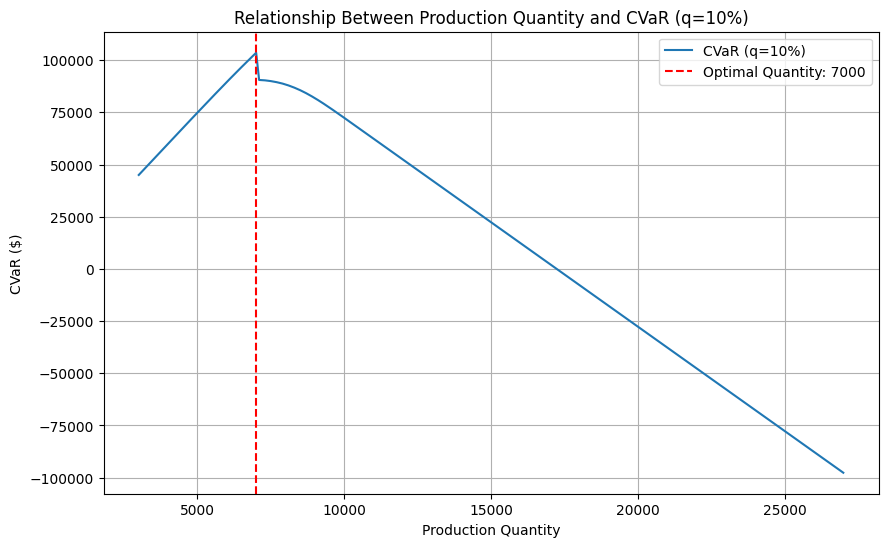

In [4]:
#2.2
# 設定 CVaR 的信心水平
q = 0.1  # q = 10%

# 儲存 CVaR 結果
CVaR = np.zeros(len(QRange))

# 計算每個生產數量的 CVaR
for i, Q in enumerate(QRange):
    #由上到下取(同一個QRange的模擬)
    ProfitDistribution = SimProfit[:, i]
    # 計算 VaR (q分位數)
    VaR = np.percentile(ProfitDistribution, q * 100)  # 10%的分位數
    # 計算 CVaR (損失情況最差 10% 的平均值)
    CVaR[i] = ProfitDistribution[ProfitDistribution <= VaR].mean()

# 找到使 CVaR 最大的生產數量
OptimalQ_CVaR = QRange[np.argmax(CVaR)]
MaxCVaR = CVaR.max()

# 結果輸出
print(f"Optimal production quantity (based on CVaR maximization): {OptimalQ_CVaR} shirts")
print(f"Maximum CVaR: ${MaxCVaR:.2f}")

# 繪圖
plt.figure(figsize=(10, 6))
plt.plot(QRange, CVaR, label='CVaR (q=10%)')
plt.axvline(OptimalQ_CVaR, color='red', linestyle='--', label=f'Optimal Quantity: {OptimalQ_CVaR}')
plt.xlabel('Production Quantity')
plt.ylabel('CVaR ($)')
plt.title('Relationship Between Production Quantity and CVaR (q=10%)')
plt.legend()
plt.grid()
plt.show()



### Q2-3

勝利時的最佳生產數量: 16200 件，最大利潤: $198023.10
落敗時的最佳生產數量: 11000 件，最大利潤: $127409.93
現實情境的期望利潤(不知道的情況下): $144015.02
勝利情境下的利潤差異(EVPI): $54008.08
落敗情境下的利潤差異(EVPI): $-16605.09


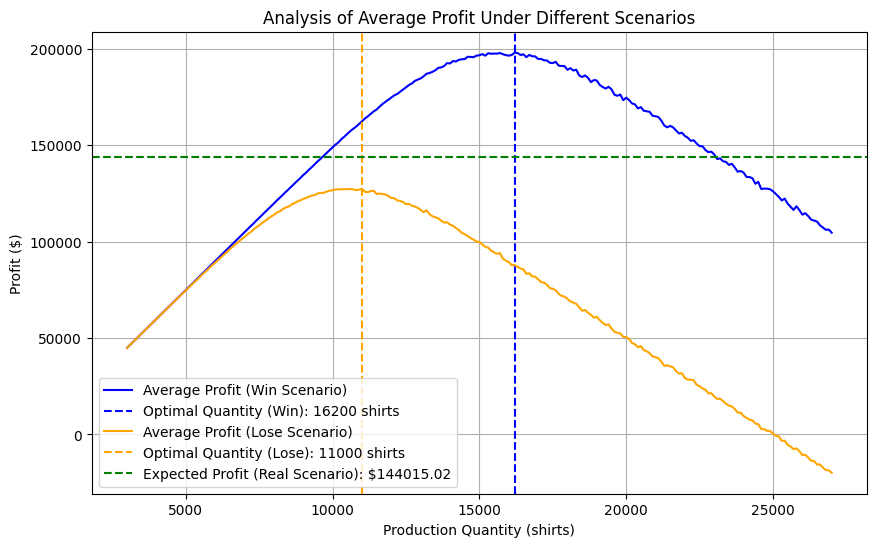

In [5]:
# 儲存結果：贏與輸的最佳生產數量及其利潤
AvgProfitWin = np.zeros(len(QRange))
AvgProfitLose = np.zeros(len(QRange))

# 勝利與落敗情況下模擬不同生產數量的平均利潤
for i, Q in enumerate(QRange):
    ProfitWin = []
    ProfitLose = []

    for s in range(Simulations):
        PreGameDemand = np.random.normal(PreGameMean, PreGameStd)  # 比賽前需求

        # 勝利情況
        PostGameDemandWin = np.random.normal(PostGameWinMean, PostGameWinStd)
        PreGameSalesWin = min(Q, PreGameDemand) * PreGamePrice
        RemainingStockWin = max(0, Q - PreGameDemand)
        PostGameSalesWin = min(RemainingStockWin, PostGameDemandWin) * PostGamePriceWin
        ProfitWin.append(PreGameSalesWin + PostGameSalesWin - Q * CostPerShirt)

        # 落敗情況
        PostGameDemandLose = np.random.gamma(KLose, ThetaLose)
        PreGameSalesLose = min(Q, PreGameDemand) * PreGamePrice
        RemainingStockLose = max(0, Q - PreGameDemand)
        PostGameSalesLose = min(RemainingStockLose, PostGameDemandLose) * PostGamePriceLose
        ProfitLose.append(PreGameSalesLose + PostGameSalesLose - Q * CostPerShirt)

    # 平均利潤
    AvgProfitWin[i] = np.mean(ProfitWin)
    AvgProfitLose[i] = np.mean(ProfitLose)

# 找到勝利和落敗的最佳生產數量
OptimalQ_Win = QRange[np.argmax(AvgProfitWin)]
OptimalQ_Lose = QRange[np.argmax(AvgProfitLose)]

# 計算勝利和落敗的期望利潤
MaxProfitWin = AvgProfitWin.max()
MaxProfitLose = AvgProfitLose.max()

# 計算差異
WinDifference = MaxProfitWin - MaxProfit
LoseDifference = MaxProfitLose - MaxProfit

# 無完美信息情境下的利潤（第一題結果）
ExpectedProfit_Real = MaxProfit


# 結果輸出
print(f"勝利時的最佳生產數量: {OptimalQ_Win} 件，最大利潤: ${MaxProfitWin:.2f}")
print(f"落敗時的最佳生產數量: {OptimalQ_Lose} 件，最大利潤: ${MaxProfitLose:.2f}")
print(f"現實情境的期望利潤(不知道的情況下): ${ExpectedProfit_Real:.2f}")
print(f"勝利情境下的利潤差異(EVPI): ${WinDifference:.2f}")
print(f"落敗情境下的利潤差異(EVPI): ${LoseDifference:.2f}")

import matplotlib.pyplot as plt
import numpy as np

# 繪製不同情境下的平均利潤曲線
plt.figure(figsize=(10, 6))

# 勝利情況
plt.plot(QRange, AvgProfitWin, label='Average Profit (Win Scenario)', color='blue')
plt.axvline(OptimalQ_Win, color='blue', linestyle='--', label=f'Optimal Quantity (Win): {OptimalQ_Win} shirts')

# 落敗情況
plt.plot(QRange, AvgProfitLose, label='Average Profit (Lose Scenario)', color='orange')
plt.axvline(OptimalQ_Lose, color='orange', linestyle='--', label=f'Optimal Quantity (Lose): {OptimalQ_Lose} shirts')

# 無完美信息的期望利潤（現實情境）
plt.axhline(ExpectedProfit_Real, color='green', linestyle='--', label=f'Expected Profit (Real Scenario): ${ExpectedProfit_Real:.2f}')

# 圖表標籤與格式
plt.xlabel('Production Quantity (shirts)')
plt.ylabel('Profit ($)')
plt.title('Analysis of Average Profit Under Different Scenarios')
plt.legend()
plt.grid()
plt.show()



## Q3(Nelder-Mead)

In [9]:
import numpy as np
from pymoo.problems.functional import FunctionalProblem
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.optimize import minimize

# 設定需求分佈
units_demanded = np.arange(0, 11)
demand_probabilities = np.array([0.01, 0.02, 0.04, 0.06, 0.09, 0.14,
                                 0.18, 0.22, 0.16, 0.06, 0.02])

# 設定交期分佈
lead_times = np.array([3, 4, 5])
lead_time_probabilities = np.array([0.2, 0.6, 0.2])

# 成本參數
holding_cost_per_day = 0.6       # 每單位每天持有成本
ordering_cost = 500              # 每次訂購固定成本
unit_cost = 250                  # 每單位商品成本
shortage_cost_per_unit = 400     # 每單位缺貨成本

# 模擬參數
days = 10                        # 模擬天數
initial_inventory = 10           # 初始存貨
num_replications = 300           # 模擬重複次數

def simulate_inventory(R, Q):
    R = int(round(R))
    Q = int(round(Q))
    if Q <= 0 or R > 1000 or Q > 1000:
        return np.inf  # 無效的 R 或 Q

    total_average_daily_cost = 0

    for replication in range(num_replications):
        on_hand = initial_inventory
        backorders = 0
        on_order = []  # (arrival_day, quantity)
        total_holding_cost = 0
        total_shortage_cost = 0
        total_ordering_cost = 0

        for day in range(days):
            # 收到今天到貨的訂單
            arriving_orders = [qty for arrival_day, qty in on_order if arrival_day == day]
            if arriving_orders:
                total_arrival_qty = sum(arriving_orders)
                on_order = [order for order in on_order if order[0] != day]
                # 先滿足缺貨
                if backorders > 0:
                    backorder_fulfillment = min(total_arrival_qty, backorders)
                    backorders -= backorder_fulfillment
                    total_arrival_qty -= backorder_fulfillment
                # 剩餘的增加到在手庫存
                on_hand += total_arrival_qty

            # 產生當日需求
            demand = np.random.choice(units_demanded, p=demand_probabilities)

            # 滿足當日需求
            if on_hand >= demand:
                on_hand -= demand
            else:
                demand_left = demand - on_hand
                on_hand = 0
                backorders += demand_left

            # 更新庫存位置
            on_order_qty = sum(qty for arrival_day, qty in on_order)
            inventory_position = on_hand + on_order_qty - backorders

            # 若庫存位置 ≤ R，則下訂單
            if inventory_position <= R:
                lead_time = np.random.choice(lead_times, p=lead_time_probabilities)
                arrival_day = day + lead_time
                on_order.append((arrival_day, Q))
                # 計算訂購成本
                total_ordering_cost += ordering_cost + Q * unit_cost

            # 計算成本
            holding_cost = holding_cost_per_day * on_hand
            shortage_cost = shortage_cost_per_unit * backorders

            total_holding_cost += holding_cost
            total_shortage_cost += shortage_cost

        total_cost = total_holding_cost + total_shortage_cost + total_ordering_cost
        average_daily_cost = total_cost / days
        total_average_daily_cost += average_daily_cost

    return total_average_daily_cost / num_replications

def cost_function(x):
    R, Q = x
    return simulate_inventory(R, Q)

# 建立以 cost_function 為目標的優化問題
problemInv = FunctionalProblem(
    n_var=2,
    objs=lambda x: cost_function(x),  # x為[ R, Q]
    xl=np.array([0, 1]),             # 下界：R>=0, Q>=1
    xu=np.array([1000, 1000])        # 上界：R<=1000, Q<=1000
)

# 你可以嘗試 Hooke-Jeeves (PatternSearch)
algorithm = PatternSearch()
algorithm2 = NelderMead()
# 或者也可以嘗試 Nelder-Mead:
# from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
# algorithm = NelderMead()

res = minimize(problemInv, algorithm)
res2 = minimize(problemInv, algorithm2)

print("使用 PatternSearch 演算法的結果:")
print("最佳的 R 和 Q 值:", res.X)
print("最小化的平均每日成本:", res.F)

print("-----------")

print("使用 Nelder-Mead 演算法的結果:")
print("最佳的 R 和 Q 值:", res2.X)
print("最小化的平均每日成本:", res2.F)



使用 PatternSearch 演算法的結果:
最佳的 R 和 Q 值: [ 5.5054159  67.33984375]
最小化的平均每日成本: [2816.38686667]
-----------
使用 Nelder-Mead 演算法的結果:
最佳的 R 和 Q 值: [ 8.62262922 72.27077787]
最小化的平均每日成本: [2878.38506667]


## Q3(暴力破解)

In [ ]:
import numpy as np

# 設定隨機種子以確保可重複性（可選）
# np.random.seed(0)

# 需求分佈
units_demanded = np.arange(0, 11)
demand_probabilities = np.array([0.01, 0.02, 0.04, 0.06, 0.09, 0.14,
                                 0.18, 0.22, 0.16, 0.06, 0.02])

# 交期分佈
lead_times = np.array([3, 4, 5])
lead_time_probabilities = np.array([0.2, 0.6, 0.2])

# 成本參數
holding_cost_per_day = 0.6       # 每單位每天持有成本
ordering_cost = 500              # 每次訂購固定成本
unit_cost = 250                  # 每單位商品成本
shortage_cost_per_unit = 400     # 每單位缺貨成本

# 模擬參數
days = 10                      # 模擬天數
initial_inventory = 10         # 初始存貨
num_replications = 5000         # 模擬重複次數

# 庫存模擬函數
def simulate_inventory(R, Q):
    R = int(round(R))
    Q = int(round(Q))
    if Q <= 0 or R > 1000 or Q > 1000:
        return np.inf  # 無效的 R 或 Q

    total_average_daily_cost = 0

    for replication in range(num_replications):
        on_hand = initial_inventory
        backorders = 0
        on_order = []  # (arrival_day, quantity)
        total_holding_cost = 0
        total_shortage_cost = 0
        total_ordering_cost = 0

        for day in range(days):
            # 收到今天到貨的訂單
            arriving_orders = [qty for arrival_day, qty in on_order if arrival_day == day]
            if arriving_orders:
                total_arrival_qty = sum(arriving_orders)
                on_order = [order for order in on_order if order[0] != day]
                # 先滿足缺貨
                if backorders > 0:
                    backorder_fulfillment = min(total_arrival_qty, backorders)
                    backorders -= backorder_fulfillment
                    total_arrival_qty -= backorder_fulfillment
                # 剩餘的增加到在手庫存
                on_hand += total_arrival_qty

            # 產生當日需求
            demand = np.random.choice(units_demanded, p=demand_probabilities)

            # 滿足當日需求
            if on_hand >= demand:
                on_hand -= demand
            else:
                demand_left = demand - on_hand
                on_hand = 0
                backorders += demand_left

            # 更新庫存位置
            on_order_qty = sum(qty for arrival_day, qty in on_order)
            inventory_position = on_hand + on_order_qty - backorders

            # 若庫存位置 ≤ R，則下訂單
            if inventory_position <= R:
                lead_time = np.random.choice(lead_times, p=lead_time_probabilities)
                arrival_day = day + lead_time
                on_order.append((arrival_day, Q))
                # 計算訂購成本
                total_ordering_cost += ordering_cost + Q * unit_cost

            # 計算成本
            holding_cost = holding_cost_per_day * on_hand
            shortage_cost = shortage_cost_per_unit * backorders

            total_holding_cost += holding_cost
            total_shortage_cost += shortage_cost

        total_cost = total_holding_cost + total_shortage_cost + total_ordering_cost
        average_daily_cost = total_cost / days
        total_average_daily_cost += average_daily_cost

    return total_average_daily_cost / num_replications

# 暴力解法
def brute_force_solution(R_range, Q_range):
    best_R, best_Q = 0, 0
    min_cost = float('inf')
    for R in R_range:
        for Q in Q_range:
            cost = simulate_inventory(R, Q)
            if cost < min_cost:
                min_cost = cost
                best_R, best_Q = R, Q
    return best_R, best_Q, min_cost

# 範圍
R_range = range(0, 101, 1)  # R 從 0 到 100
Q_range = range(1, 101, 1)  # Q 從 1 到 100

# 找到最佳解
best_R, best_Q, min_cost = brute_force_solution(R_range, Q_range)

print("最佳的 R 值:", best_R)
print("最佳的 Q 值:", best_Q)
print("最小化的平均每日成本:", min_cost)


最佳的 R 值: 8
最佳的 Q 值: 69
最小化的平均每日成本: 2849.3424999999993
